# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
- Introduction: Business Problem
- Data
- Methodology
- Analysis
- Results and Conclusion


## Introduction: Business Problem

The success of any restaurant depends on several factors such as menu, quality of food, prices and so on. However, one of the main factors for its ultimate success is location. Therefore, using supply and demand laws, building Chinese restaurant should be in the neighborhood where percentage of Chinese people living in that area must be high and where there should be not many chinese restaurants, so that we can avoid competition. 

My job here is to find optimal location for the restaurant using data science so that restaurant could be profitable and prosper in the area.

## Data

1) Neighborhoods with postal codes and borough will be scraped from Wikipedia.
(link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) 

2) Geographical coordinates for each neighborhood will be obtained from the following link:
(https://cocl.us/Geospatial_data)

3) Census data about Toronto's population, chinese population and household income will be obtained from:
Toronto’s Open Data Portal 
(link: http://map.toronto.ca/wellbeing)

Using data I will identify:
    - Geographical coordinates of neighborhoods in Toronto
    - All the restaurants in those neighborhoods using Foursquare API and specifically, Asian restaurants
    - Chinese people living in the neighborhoods

### Needed libraries

In [1]:
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
import folium
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

## Getting Toronto's total population data and Chinese population by neighborhood

In [2]:
toronto_population = pd.read_csv('C:\\Users\\Trust\\Downloads\\wellbeing_toronto.csv')
toronto_population.rename(columns={'After-Tax Household Income': 'Household Income'}, inplace=True)
toronto_population.drop(['Neighbourhood Id', 'Combined Indicators'], axis=1, inplace=True)
toronto_population.head()

,Neighbourhood,Household Income,Total Population,Chinese
0,West Humber-Clairville,59703.0,33312.0,470.0
1,Mount Olive-Silverstone-Jamestown,46986.0,32954.0,285.0
2,Thistletown-Beaumond Heights,57522.0,10360.0,110.0
3,Rexdale-Kipling,51194.0,10529.0,165.0
4,Elms-Old Rexdale,49425.0,9456.0,105.0


## Creating dataframe containing coordinates of each neighborhood and then merging it with Toronto population dataframe

In [3]:
df_geo = pd.read_csv("https://cocl.us/Geospatial_data")
df = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050')[0]
df = df[df.Borough!='Not assigned']
df = pd.merge(df, df_geo, left_on='Postcode', right_on='Postal Code').drop(['Postal Code', 'Postcode', 'Borough'], axis=1)
df = pd.merge(df, toronto_population, on='Neighbourhood', how='left').dropna(how='any', axis=0).reset_index(drop=True)
df.head()

,Neighbourhood,Latitude,Longitude,Household Income,Total Population,Chinese
0,Victoria Village,43.725882,-79.315572,43743.0,17510.0,730.0
1,Rouge,43.806686,-79.194353,72784.0,46496.0,2100.0
2,Malvern,43.806686,-79.194353,53425.0,43794.0,3275.0
3,Highland Creek,43.784535,-79.160497,87321.0,12494.0,955.0
4,Flemingdon Park,43.725900,-79.340923,43511.0,21933.0,1015.0


In [33]:
df['Household Income'].mean()

52090.885714285716

## Getting the percentage of Southeast Asian in the total population

In [4]:
df.rename(columns={'   Chinese': 'Chinese'}, inplace=True)
df['Percentage of Chinese'] = df['Chinese'] / df['Total Population'] * 100
df.drop(['Total Population', 'Chinese'], axis=1, inplace=True)

In [34]:
df.head()

,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Chinese
0,Victoria Village,43.725882,-79.315572,43743.0,4.169046
1,Rouge,43.806686,-79.194353,72784.0,4.516518
2,Malvern,43.806686,-79.194353,53425.0,7.478193
3,Highland Creek,43.784535,-79.160497,87321.0,7.643669
4,Flemingdon Park,43.725900,-79.340923,43511.0,4.627730


## Create a Folium map 

In [5]:
address = 'Toronto'
geolocator = Nominatim(user_agent='to_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("The geographical coordinates of Toronto are {}, {}".format(latitude, longitude))

The geographical coordinates of Toronto are 43.6534817, -79.3839347


In [6]:
# Folium mapping
import folium
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
  label = '{}'.format(neighbourhood)
  label = folium.Popup(label)
  folium.CircleMarker(
      [lat,lng],
      radius=8,
      color='blue',
      popup=label,
      fill_color='#3186cc',
      fill_opacity=0.7,
      fill=True

  ).add_to(map_Toronto)

map_Toronto

## Defining Foursquare credentials and version

In [7]:
CLIENT_ID = 'WHH03MRSDOKYL4NSTHXULIJHLE4OZQMUNV55V1NCQSIHTVTC' # your Foursquare ID
CLIENT_SECRET = 'RQKZ4GIY4EQMDWCLCQXEGYYUI1QBKUUXHJDGLNFQRSJBVVVQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Get the top 100 venues that are in Toronto within a radius of 1500 meters

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
  venues_list = []
  for name, lat, lng in zip(names, latitudes, longitudes):
    print(name)

    #create the API request url
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

    # make the GET request
    results = requests.get(url).json()['response']['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results
        ])
  
  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = ['Neighbourhood',
                           'Neighbourhood Latitude',
                           'Neighbourhood Longitude',
                           'Venue',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue Category']

  return(nearby_venues)

In [9]:
# run the function above to each neighborhood and create a new dataframe called manhattan_venues
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude'])

toronto_venues

Victoria Village
Rouge
Malvern
Highland Creek
Flemingdon Park
Humewood-Cedarvale
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Woburn
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Scarborough Village
Henry Farm
Little Portugal
Ionview
Kennedy Park
Bayview Village
Oakridge
Humber Summit
Cliffcrest
Mount Dennis
Weston
Dorset Park
Forest Hill North
Willowdale West
Roncesvalles
Agincourt North
Milliken
New Toronto
Alderwood
Long Branch


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
1,Victoria Village,43.725882,-79.315572,Armenian Kitchen,43.731071,-79.305390,Middle Eastern Restaurant
2,Victoria Village,43.725882,-79.315572,Aga Khan Museum,43.725105,-79.332076,History Museum
3,Victoria Village,43.725882,-79.315572,Sultan Of Samosas,43.718823,-79.304350,Indian Restaurant
4,Victoria Village,43.725882,-79.315572,Jatujak,43.736208,-79.307668,Thai Restaurant
...,...,...,...,...,...,...,...
1786,Long Branch,43.602414,-79.543484,Samko & Miko,43.601666,-79.528513,Toy / Game Store
1787,Long Branch,43.602414,-79.543484,The Beer Store,43.594755,-79.533663,Beer Store
1788,Long Branch,43.602414,-79.543484,Douglas Park,43.609872,-79.537724,Park
1789,Long Branch,43.602414,-79.543484,Connorvale Park,43.607201,-79.530702,Park


Check how many venues were returned for each neighbourhood

In [10]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt North,78,78,78,78,78,78
Alderwood,42,42,42,42,42,42
Bathurst Manor,39,39,39,39,39,39
Bayview Village,16,16,16,16,16,16
Cliffcrest,41,41,41,41,41,41
Dorset Park,61,61,61,61,61,61
Flemingdon Park,85,85,85,85,85,85
Forest Hill North,100,100,100,100,100,100
Guildwood,32,32,32,32,32,32


## Analyzing each neighborhood with One Hot encoding

In [11]:
#one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix ='', prefix_sep='')
# add neighbourhood to column back to data frame
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Group rows by neighbourhood and by taking the mean of the frequency of occurrence of Asian restaurants

In [12]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped = toronto_grouped[['Neighbourhood', 'Asian Restaurant']]
toronto_grouped.set_index('Neighbourhood', inplace=True)

## Methodology

In this project, all neighborhoods with low density Asian restaurants and high density of Chinese people will be identified to find optimal location for the restaurant.

Firstly, I have have collected required data such as neighborhood location, all asian restaurants located in the neighborhoods and Chinese people living in those areas.

Secondly, using gathered data, I will plot 2 bar charts which show amount of Chinese people living in the neighborhoods and Asian restaurants located in the neighborhoods.

The last but not least, I will conduct analysis using k-means clustering in order to find the best locations for the restaurant.

## Analysis

Plotting a bar graph to showcase the frequency distribution of Asian restaurants in each neighbourhood.

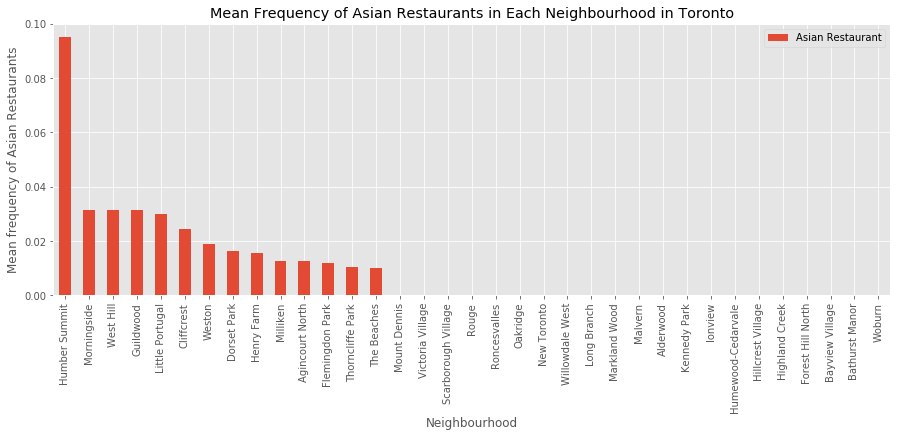

In [15]:
toronto_grouped.sort_values(by='Asian Restaurant', ascending=False, inplace=True)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

toronto_grouped.plot(kind='bar', figsize=(15,5))

plt.title('Mean Frequency of Asian Restaurants in Each Neighbourhood in Toronto')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean frequency of Asian Restaurants')

plt.show()

The above graph shows that there are a lot of Asian restaurants in Humber Summit followed by Morningside, Guildwood and West Hill. Therefore, it is not recommended to build Asian restaurant at abovementioned areas.

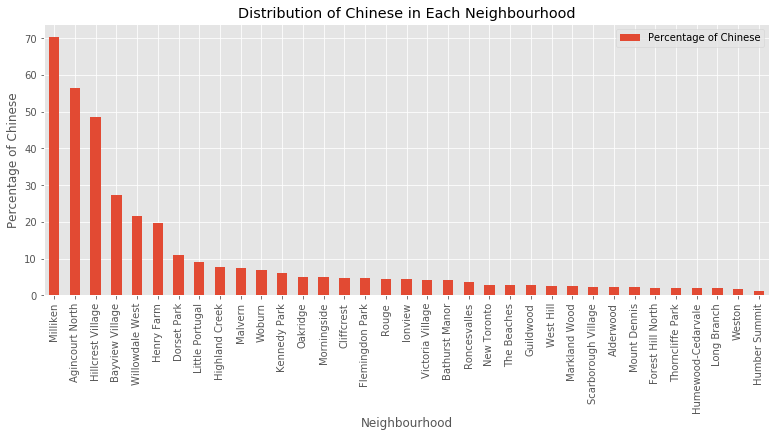

In [16]:
df_ethnic = df[['Neighbourhood', 'Percentage of Chinese']].set_index('Neighbourhood')

# sort by descending order
df_ethnic.sort_values(by='Percentage of Chinese', ascending=False, inplace=True)

#plot bar graph
df_ethnic.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Chinese in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Percentage of Chinese')

plt.show()

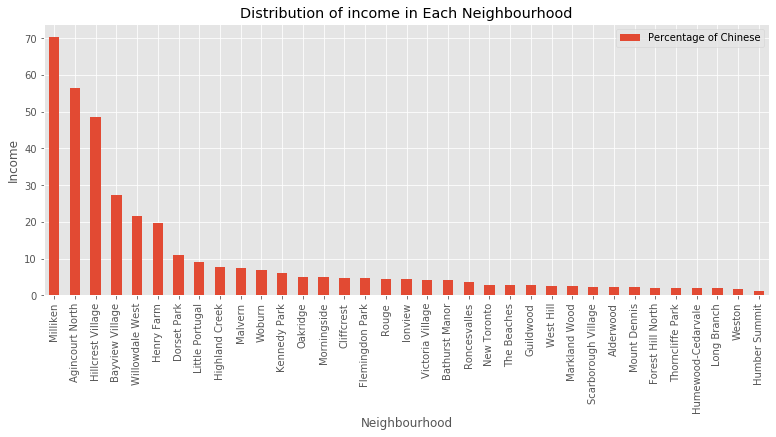

In [17]:
df_income = df[['Neighbourhood', 'Household Income']].set_index('Neighbourhood')

# sort by descending order
df_income.sort_values(by='Household Income', ascending=False, inplace=True)

#plot bar graph
df_ethnic.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of income in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Income')

plt.show()

It can be inferred from the graph that Milliken, AginCourt North and Hillcrest Village are the most populated areas with Chinese people.

## Finalizing a dataframe for clustering

In [18]:
# merge df with toronto_grouped
df_final = pd.merge(df, toronto_grouped, on='Neighbourhood')

In [19]:
df_final.head()

,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Chinese,Asian Restaurant
0,Victoria Village,43.725882,-79.315572,43743.0,4.169046,0.000000
1,Rouge,43.806686,-79.194353,72784.0,4.516518,0.000000
2,Malvern,43.806686,-79.194353,53425.0,7.478193,0.000000
3,Highland Creek,43.784535,-79.160497,87321.0,7.643669,0.000000
4,Flemingdon Park,43.725900,-79.340923,43511.0,4.627730,0.011765


## Clustering

In [20]:
# Normalizing the data
from sklearn.preprocessing import StandardScaler

X = df_final.values[:, 3:]
X = np.nan_to_num(X)
X = StandardScaler().fit_transform(X)
X

array([[-7.63184014e-01, -3.89814136e-01, -5.55371027e-01],
       [ 1.89181483e+00, -3.68124829e-01, -5.55371027e-01],
       [ 1.21967973e-01, -1.83255754e-01, -5.55371027e-01],
       [ 3.22082273e+00, -1.72926696e-01, -5.55371027e-01],
       [-7.84394018e-01, -3.61182906e-01,  9.37249630e-02],
       [-2.59537836e-01, -5.21861043e-01, -5.55371027e-01],
       [ 1.11591265e+00, -4.96273758e-01, -5.55371027e-01],
       [ 1.42501190e+00, -4.76954942e-01,  1.16879020e+00],
       [-1.84845709e-01, -3.35352991e-01,  1.16879020e+00],
       [-4.83431372e-01, -4.93951144e-01,  1.16879020e+00],
       [ 1.72478605e+00, -4.72051020e-01, -3.63943547e-03],
       [-3.82409585e-01, -2.16483440e-01, -5.55371027e-01],
       [ 5.11153266e-01,  2.38177002e+00, -5.55371027e-01],
       [-9.27833202e-02, -3.92469634e-01, -5.55371027e-01],
       [-1.22925557e+00, -5.21409899e-01,  3.15774746e-02],
       [-1.08883072e+00, -5.04484725e-01, -5.55371027e-01],
       [-4.05173770e-01,  5.72714540e-01

In [21]:
df_normalized = pd.DataFrame(X)
df_normalized.rename(columns={0: 'Household Income', 1: '% Chinese people', 2: '# of Asian Restaurants'}, inplace=True)
df_normalized.head()

,Household Income,% Chinese people,# of Asian Restaurants
0,-0.763184,-0.389814,-0.555371
1,1.891815,-0.368125,-0.555371
2,0.121968,-0.183256,-0.555371
3,3.220823,-0.172927,-0.555371
4,-0.784394,-0.361183,0.093725


## Finding optimal number of clusters, k

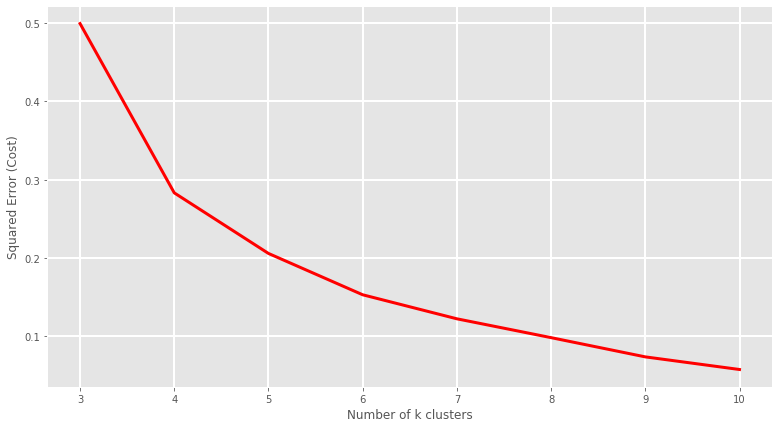

In [22]:
error_cost=[]

for i in range(3, 11):
  KM = KMeans(n_clusters=i, max_iter=100)
  try:
    KM.fit(df_normalized)

  except ValueError:
    print('Error on line', i)

  # calculate squared error for the clustered points
  error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

C:\Users\Trust\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA3339F788>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=10,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=True, metric='distortion', timings=True)

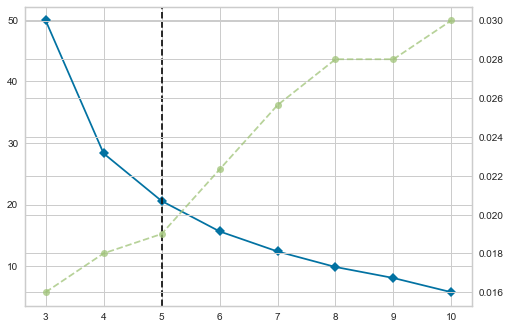

In [23]:
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,11))

visualizer.fit(X)
visualizer

After analysing using elbow method using distortion score & Squared error for each K value, looks like K = 5 is the best value.

## Clustering the Toronto Neighborhood Using K-Means with K = 5

In [24]:
# set number of clusters
Ks = 5

# run k-means clustering
kmeans = KMeans(n_clusters=Ks, random_state=0).fit(df_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 0, 1, 0, 0, 1, 4, 4, 4])

In [25]:
#Creating dataframe that includes the cluster
df_normalized.drop(['Household Income', '% Chinese people'], axis=1, inplace=True)
df_clustered = pd.merge(df, df_normalized, left_index=True, right_index=True)
df_clustered.insert(0, 'Cluster Label', kmeans.labels_)

## Visualizing cluster on a map

In [27]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start = 11)

#set color schemes for the clusters
x = np.arange(Ks)
ys = [i + x + (i*x)**2 for i in range(Ks)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustered['Latitude'], df_clustered['Longitude'], df_clustered['Neighbourhood'], df_clustered['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining clusters 

Cluster 0

In [28]:
df_clustered.loc[df_clustered['Cluster Label'] == 0]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Chinese,# of Asian Restaurants
0,0,Victoria Village,43.725882,-79.315572,43743.0,4.169046,-0.555371
2,0,Malvern,43.806686,-79.194353,53425.0,7.478193,-0.555371
4,0,Flemingdon Park,43.725900,-79.340923,43511.0,4.627730,0.093725
5,0,Humewood-Cedarvale,43.693781,-79.428191,49252.0,2.053603,-0.555371
11,0,Woburn,43.770992,-79.216917,47908.0,6.945873,-0.555371
13,0,Bathurst Manor,43.754328,-79.442259,51076.0,4.126504,-0.555371
14,0,Thorncliffe Park,43.705369,-79.349372,38645.0,2.060830,0.031577
15,0,Scarborough Village,43.744734,-79.239476,40181.0,2.331978,-0.555371
16,0,Henry Farm,43.778517,-79.346556,47659.0,19.589137,0.306710
18,0,Ionview,43.727929,-79.262029,42971.0,4.398505,-0.555371


Cluster 1

In [29]:
df_clustered.loc[df_clustered['Cluster Label'] == 1]


,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Chinese,# of Asian Restaurants
1,1,Rouge,43.806686,-79.194353,72784.0,4.516518,-0.555371
3,1,Highland Creek,43.784535,-79.160497,87321.0,7.643669,-0.555371
6,1,Markland Wood,43.643515,-79.577201,64297.0,2.463521,-0.555371
10,1,The Beaches,43.676357,-79.293031,70957.0,2.851579,-0.003639
33,1,Alderwood,43.602414,-79.543484,61402.0,2.281400,-0.555371


Cluster 2

In [30]:
df_clustered.loc[df_clustered['Cluster Label'] == 2]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Chinese,# of Asian Restaurants
12,2,Hillcrest Village,43.803762,-79.363452,57682.0,48.570922,-0.555371
30,2,Agincourt North,43.815252,-79.284577,55893.0,56.538316,0.151977
31,2,Milliken,43.815252,-79.284577,55464.0,70.431281,0.151977


Cluster 3

In [31]:
df_clustered.loc[df_clustered['Cluster Label'] == 3]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Chinese,# of Asian Restaurants
22,3,Humber Summit,43.756303,-79.565963,53272.0,1.087307,4.699216


Cluster 4

In [32]:
df_clustered.loc[df_clustered['Cluster Label'] == 4]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Chinese,# of Asian Restaurants
7,4,Guildwood,43.763573,-79.188711,67678.0,2.773016,1.168790
8,4,Morningside,43.763573,-79.188711,50069.0,5.041535,1.168790
9,4,West Hill,43.763573,-79.188711,46803.0,2.500730,1.168790
17,4,Little Portugal,43.647927,-79.419750,52519.0,9.222958,1.099824
23,4,Cliffcrest,43.716316,-79.239476,60384.0,4.800753,0.790316


## Results and conclusion

In conclusion, after analyzing all the clusters, cluster 2 is the best area to build Chinese restaurant. All the areas in the cluster 0, potentially good places for building Chinese restaurant, because density of Chinese people living in the areas belonging to cluster 2 is high and density of Asian restaurants is low. Moreover, specifically, Hillcrest Village is the best one as there are a lot of Chinese people but no Chinese restaurants.